In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from read_image import match_image, get_images
from image_processing import resize_image
from tensorflow.keras.applications import VGG16
import tensorflow.keras.preprocessing as tfp
%cd ..

In [ ]:
tif_path_raw = './data/mitoraw_tifs/cmap15_P1_B3A_tifs'
data = pd.read_csv("./data/mitocontrolset.csv")
image_name = match_image(tif_path_raw, data.loc[:, "cell_name"].tolist())
image_list = get_images(tif_path_raw, image_name)
# resize the image to the uniform canvas size (512, 512)
image_list = [resize_image(image, target_size = (512, 512)) for image in image_list]

In [33]:
image_vector_list = [image.reshape((1,-1)) for image in image_list]

In [35]:
image_df = pd.DataFrame(np.concatenate(image_vector_list))

## Feature Extraction
pre-trained model for feature extraction

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

def extract_features(image:np.ndarray, model):
    """
    Function to extract features from an image.

    Returns:
        np.ndarray with shape (1, 16 * 16 * 2048) 
    """
    img_array = tfp.image.img_to_array(image)  # shape (512, 512, 1)
    img_array = np.repeat(img_array, 3, axis=-1)  # Convert to 3 channels
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize for ImageNet

    # Extract features
    features = model.predict(img_array)
    return features.flatten()  # Flatten to 1D vector

In [52]:
features = np.array([extract_features(image, model) for image in image_list])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
features.shape

(1145, 524288)

## UMap Dimension Reduction

In [55]:
reducer = umap.UMAP(n_components = 2, random_state=42)
reducer.fit(features)

/Users/daixinming/anaconda3/envs/mito/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [58]:
embedding = reducer.transform(features)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(1145, 2)

In [59]:
label = data['Guide_ID'].astype('category').cat.codes
label.value_counts()

16    185
21    136
20    123
11     82
4      70
18     67
22     64
19     55
2      46
9      38
7      34
17     28
15     27
12     25
8      23
23     22
26     18
0      17
25     16
14     14
13     12
3      12
27     12
6       9
5       3
1       3
10      3
24      1
Name: count, dtype: int64

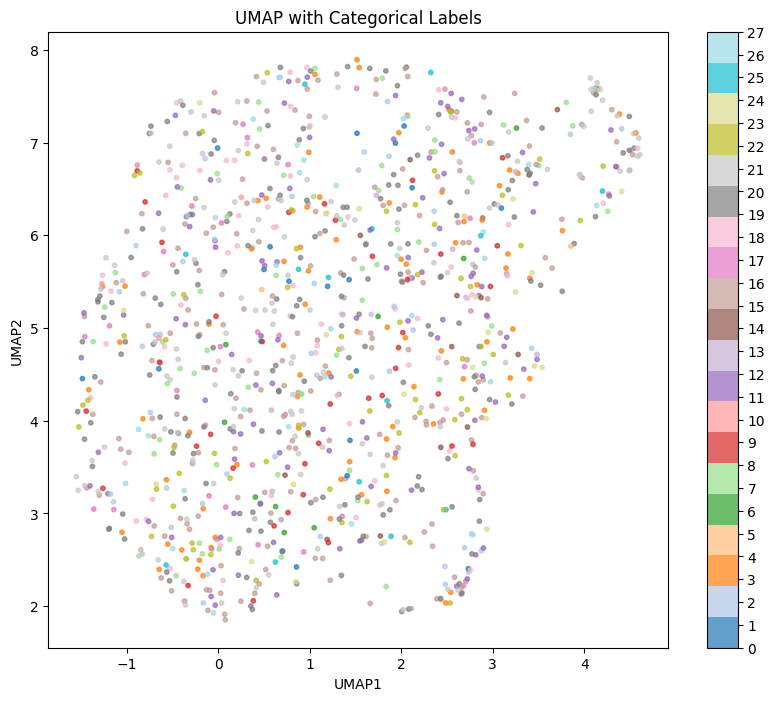

In [60]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=label, cmap='tab20', s=10, alpha=0.7)
plt.title('UMAP with Categorical Labels')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(scatter, ticks=range(len(label.unique())))
plt.show()